# Maximum Likelihood method

In [1]:

#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b52107f0e112944e6d430c045ff387e55bad2fd3644cd32eb4b8d17796e27518
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 656.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB

In [2]:

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

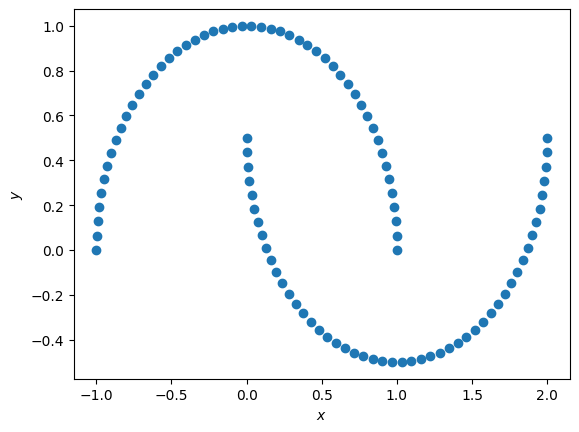

In [3]:

from sklearn import datasets

n_samples = 100
X, y = datasets.make_moons(n_samples=n_samples, noise=0.0, random_state=1)
plt.scatter(X[:,0], X[:,1])
plt.xlabel('$x$')
plt.ylabel('$y$');

In [4]:

import torch
import pyro
from pyro import distributions
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions.transforms as T
from pyro.optim import Adam

torch.manual_seed(0)

In [5]:

# 変換前のガウス分布
base_dist = distributions.Normal(torch.zeros(2), torch.ones(2))
# 正規化流に使用する関数
transform = T.spline_coupling(2)
# 正規化流によって変換された確率分布
transformed_dist = distributions.TransformedDistribution(base_dist, [transform])

## Train

Text(0, 0.5, '$Loss$')

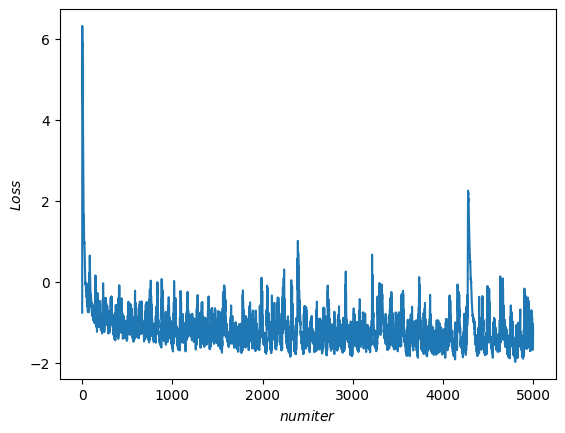

In [8]:
steps = 5000

#convert to Tensor
dataset = torch.tensor(X,dtype=torch.float)
#optimizer
optimizer=torch.optim.Adam(transform.parameters(),lr=1e-2)

loss_list = []
for step in range(steps):
  #init
  optimizer.zero_grad()
  #loss
  loss = -transformed_dist.log_prob(dataset).mean()
  #backward
  loss.backward()
  #update
  optimizer.step()
  #reset spline_coupling transformation cache
  transformed_dist.clear_cache()

  loss_list.append(loss.detach().numpy())

plt.plot(loss_list)
plt.xlabel("$num iter$")
plt.ylabel("$Loss$")

## Visualize prediction

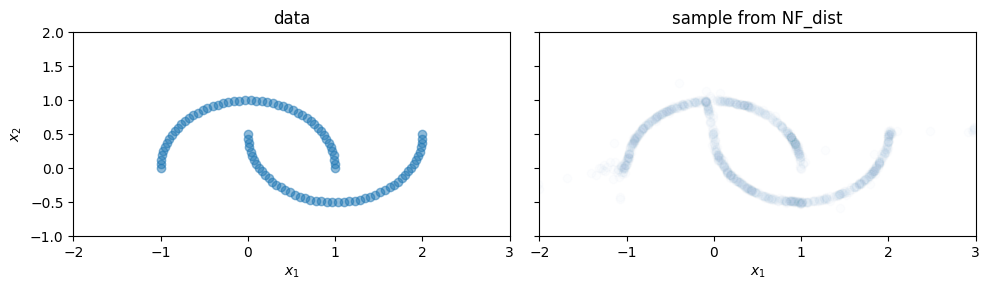

In [9]:
fig,ax = plt.subplots(figsize=(10,3),ncols=2,sharex=True,sharey=True)
#training data
ax[0].scatter(X[:,0],X[:,1],label="data",alpha=0.5)
#normalizingFlow samples
sample_from_nf_dist = transformed_dist.sample(torch.Size([1000]))
ax[1].scatter(x=sample_from_nf_dist[:,0],y=sample_from_nf_dist[:,1],alpha=0.01)

ax[0].set_xlim(-2,3);ax[0].set_ylim(-1,2)
ax[0].set_title(r'data')
ax[1].set_title(r'sample from NF_dist')
ax[0].set_xlabel(r'$x_1$')
ax[1].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
plt.tight_layout();
